In [1]:
#coding=utf-8
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
import pandas as pd


# Read raw data

In [2]:
## Load the train data
train = np.load("train.npz")
X_train, y_train = train["X"], train["y"]

## Load the test data
X_test = np.load("test.npz")["X"]


# Plot data representatives

In [3]:
# Arrange images as a 10x10 matrix with each class in the corresponding row.
image_w = 28
image_h = 28
N = y_train.shape[0]
image_classes = []
for target_class in range(10):
    class_inds = np.where(y_train == target_class)[0]
    # select 10 random sub inds 
    class_sub_inds = np.random.choice(class_inds, 10)
    image_classes.append(X_train[class_sub_inds, :])

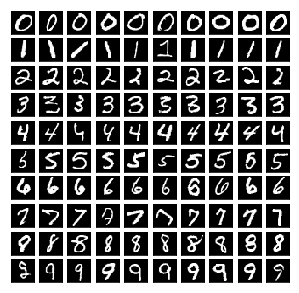

In [4]:
#plot selected representatives
n_row = 10
n_col = 10
plt.figure(figsize=(n_col/2, n_row/2))
for i in range (0, n_row):
    for j in range(0, n_col):
        plt.subplot(n_row, n_col, i*n_row + j + 1)
        plt.imshow(image_classes[i][j].reshape((image_h, image_w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

# Apply and plot PCA

In [5]:
from sklearn.decomposition import PCA, KernelPCA

In [6]:
# make PCA embedding from 784d feature space into 2d space
pca = PCA(n_components=2)
sub_inds = np.random.choice(X_train.shape[0], 10000)
embedding = pca.fit_transform(X_train[sub_inds])

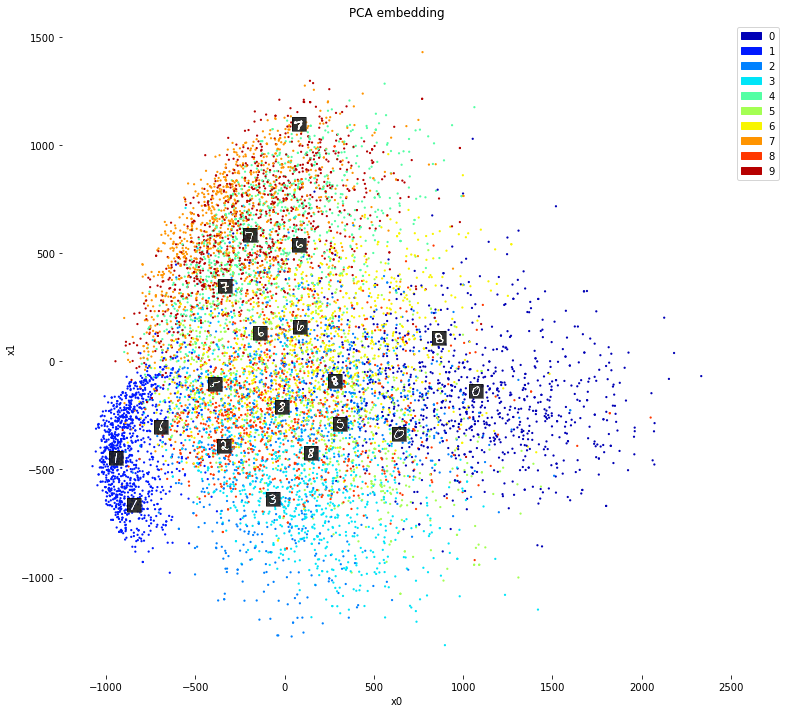

In [7]:
# plot embedding
x0 = [x[0] for x in embedding]
x1 = [x[1] for x in embedding]
colors = [cm.jet((y_ + 0.5)/10) for y_ in y_train[sub_inds]]
plt.figure(figsize=(12, 12))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
patches = [mpatches.Patch(color=cm.jet((target_class + 0.5)/10), 
                          label=str(target_class)
                         ) 
           for target_class in range(10)]
# scatter some representatives
shown = [np.array([np.inf, np.inf])]
np.random.seed(1)
for i in np.random.choice(len(sub_inds), 35):
    imagebox = OffsetImage(X_train[sub_inds[i]].reshape(28, 28), cmap=plt.cm.gray, zoom = 0.5, alpha = 0.8)
    annbox = AnnotationBbox(imagebox, embedding[i], pad = 0.0, bboxprops={'alpha':0.5})
    dists = np.linalg.norm((np.array(shown) - embedding[i]), axis = 1)
    if np.min(dists) > 200: # this is needed to limit the minimum distance between representatives
        ax.add_artist(annbox)
        shown.append(embedding[i])
plt.draw()
plt.legend(handles=patches, loc = 2, bbox_to_anchor=(1.0, 1.0))
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('PCA embedding');

# Train model

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, train_size=0.1)

In [10]:
from sklearn.manifold import TSNE

In [21]:
print('Reduction...')
train_label = np.array(y_train)
train_data = np.array(X_train)
print('Original dimension: {}'.format(len(train_data[0])))
pca = PCA(n_components=47, whiten=True)
pca.fit(train_data)
train = pca.transform(train_data)
print('Reduced dimension: {}'.format(len(train[0])))

Reduction...
Original dimension: 784
Reduced dimension: 47


In [22]:
print('Train SVM...')
from sklearn.svm import SVC
svc = SVC()
svc.fit(train, train_label)

Train SVM...


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
print('Predicting...')
test_data = np.array(X_test)
test = pca.transform(test_data)
y_pred = svc.predict(test)

Predicting...


In [26]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv_scores = cross_val_score(svc, test_data, y_pred)

In [ ]:
cv_scores.mean()

# Make submission

In [24]:
## Make a submission
# y_pred = model.predict(X_test)
sub_ = pd.DataFrame.from_items([("id", np.arange(X_test.shape[0], dtype=np.int)),
                                ("label", y_pred)])
sub_.to_csv("submission.csv", index=False)

In [ ]:
cv_scores